In [1]:
from functions import *
import numpy as np

In [2]:


T = 1000
T_test = 500

# hidden data (that we try to estimate)
A = np.array([[0.5, 0.5], [0.8, 0.2]]) # columns and rows indexed by (rain, no rain)
B = np.array([[0.8, 0.2], [0.15, 0.85]]) # rows indexed by (rain, no rain), columns by (umbrella, no umbrella)
pi = np.array([0.5, 0.5]) # (prob for rain, prob for no rain)

# we use A, B and pi to construct a HMM environment with two states and two observable values
observations = np.empty(T + T_test)
states = np.empty(T + T_test)

states[0] = int(np.random.uniform() > pi[0]) # 0 = rain
observations[0] = int(np.random.uniform() > B[int(states[0]), 0]) # 0 = umbrella

for t in range(1, T + T_test):
    prob_rain = A[int(states[t - 1]), 0]
    states[t] = int(np.random.uniform() > prob_rain)
    prob_umb = B[int(states[t]), 0]
    observations[t] = int(np.random.uniform() > prob_umb)

observations_total = [int(t) for t in observations]
states_total = [int(t) for t in states]
states = states_total[:T]
observations = observations_total[:T]
observations_test = observations_total[T:]
states_test = states_total[T:]

A_real = A.copy()
B_real = B.copy()
pi_real = pi.copy()

print('true states, hidden to model (0 = rain, 1 = no rain):'); print(states)
print()
print('true observations, for training the model (0 = umbrella, 1 = no umbrella):'); print(observations)
print()
print('real matrix A (hidden to model):'); print(A_real)
print()
print('real matrix B (hidden to model):'); print(B_real)
print()
print('real starting distribution vector pi (hidden to model):'); print(pi_real)

true states, hidden to model (0 = rain, 1 = no rain):
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

In [3]:

pct_change_ll_tol = 0.01 # eg. stop iteration per attempt when log likelyhood hasn't
# changed more than 1%
max_attempt_per_iter = 20
n_attempts = 100

# these will store data from every run
# structure: list of lists (inner list = data per iteration)
ll_list = []
diff_norms_A = []
diff_norms_B = []
diff_norms_pi = []

# these will store data from every run
# stucture: list of floats (one per attempt, not one per iteration)
pct_states_matched_viterbi = []
frac_correct_states_predicted_list = []
frac_correct_obs_predicted_list = []

for attempt in range(n_attempts):

    prev_ll = 1.0
    log_ll = 2.0

    this_attempt_ll_list = []
    this_diff_norms_A = []
    this_diff_norms_B = []
    this_diff_norms_pi = []

    A_real_first_col = A_real[:, 0]
    
    # initializing random guesses for A
    #A_first_col = np.clip(A_real_first_col + np.random.normal(0, 0.2, 2), a_min=0.1, a_max=0.9)
    A_first_col = np.random.uniform(0.1, 0.9, 2)

    A = np.empty((2, 2))
    A[:, 0] = A_first_col
    A[:, 1] = 1 - A_first_col

    B_real_first_col = B_real[:, 0]

    # initializing random guesses for B
    #B_first_col = np.clip(B_real_first_col + np.random.normal(0, 0.05, 2), a_min=0.1, a_max=0.9)
    B_first_col = np.random.uniform(0.1, 0.9, 2)

    B = np.empty((2, 2))
    B[:, 0] = B_first_col
    B[:, 1] = 1 - B_first_col

    # initializing random guesses for pi
    #p = np.clip(pi_real[0] + np.random.normal(0, 0.05), a_min=0.1, a_max=0.9)
    p = np.random.uniform(0.1, 0.9)
    pi = np.array([p, 1 - p])
    
    loga = np.log(A)
    logb = np.log(B)
    logpi = np.log(pi)

    this_attempt_count = 0

    while abs(prev_ll - log_ll) / prev_ll > pct_change_ll_tol and this_attempt_count < max_attempt_per_iter:
        prev_ll = log_ll

        # E step
        logalpha, scaling = forward_obs(loga, logb, T, 2, logpi, observations)
        logbeta = backward_obs(loga, logb, T, 2, scaling, observations)
        loggamma = compute_gamma(logalpha, logbeta, T, 2)
        logxi = compute_xi_obs(logalpha, logbeta, loga, logb, observations, T, 2)

        # M step
        loga = compute_a(loggamma, logxi, T, 2)
        logb = compute_b_obs(loggamma, observations, T, 2, 2)
        logpi = loggamma[0, :]

        # store data from this iteration
        #log_ll = np.logaddexp.reduce([logalpha[-1, i] for i in range(2)])
        log_ll = np.sum(scaling)
        this_attempt_ll_list.append(log_ll)
        this_diff_norms_A.append(np.linalg.norm(np.exp(loga) - A_real))
        this_diff_norms_B.append(np.linalg.norm(np.exp(logb) - B_real))
        this_diff_norms_pi.append(np.linalg.norm(np.exp(logpi) - pi_real))

        this_attempt_count += 1

    A = np.exp(loga)
    A /= A.sum(axis=1, keepdims=True)
    B = np.exp(logb)
    B /= B.sum(axis=1, keepdims=True)
    pi = np.exp(logpi)
    pi /= pi.sum()

    A = np.clip(A, 1e-10, 1)
    B = np.clip(B, 1e-10, 1)

    # store data from this attempt
    ll_list.append(this_attempt_ll_list)

    diff_norms_A.append(this_diff_norms_A)
    diff_norms_B.append(this_diff_norms_B)
    diff_norms_pi.append(this_diff_norms_pi)

    # test model on training data

    # first, use the Hungarian method to match the most likely B_real orientation, given the
    # orientation of B
    perm = match_states_by_B(B, B_real)
    pi_p, A_p, B_p = permute_model_disc(pi, A, B, perm)

    logpi_p = np.log(pi_p)
    loga_p = np.log(A_p)
    logb_p = np.log(B_p)
    
    # assuming we have access to the future observations, we will test the model using the viterbi path
    # algorithm, to see how well it can predict the hidden state variables, given these observations
    states, p = viterbi_disc(logpi_p, logb_p, loga_p, observations_test, T_test)
    pct_matched = 1 - np.count_nonzero(np.logical_xor(states, states_test)) / len(states)
    pct_states_matched_viterbi.append(pct_matched)

    # assuming we are at time T and we wanted to predict the future states and observations up untill
    # t = T_test, we will try to predict these values and see how well the model generalizes
    predicted_obs = np.empty(T_test)
    predicted_states = np.empty(T_test)

    states_p_dist = np.exp(loggamma[-1, :])
    predicted_states[0] = np.argmax(states_p_dist)
    predicted_obs[0] = np.argmax(B_p[int(predicted_states[0]), :])

    # generate prediction states and observations using A and B
    for k in range(1, T_test):

        # prediction of states
        states_p_dist = states_p_dist @ A_p
        states_p_dist /= states_p_dist.sum()
        predicted_states[k] = np.argmax(states_p_dist)
        # determine the predicted observation by taking the most likely observation, given the
        # predicted state value
        predicted_obs[k] = np.argmax(B_p[int(predicted_states[k]), :])

    # save the fraction of correctly predicted states and observations
    frac_correct_states_predicted = 1 - np.count_nonzero(np.logical_xor(states_test, predicted_states)) / len(predicted_states)
    frac_correct_obs_predicted = 1 - np.count_nonzero(np.logical_xor(observations_test, predicted_obs)) / len(predicted_obs)

    frac_correct_states_predicted_list.append(frac_correct_states_predicted)
    frac_correct_obs_predicted_list.append(frac_correct_obs_predicted)

Plot the log-likelyhood values of each attempt

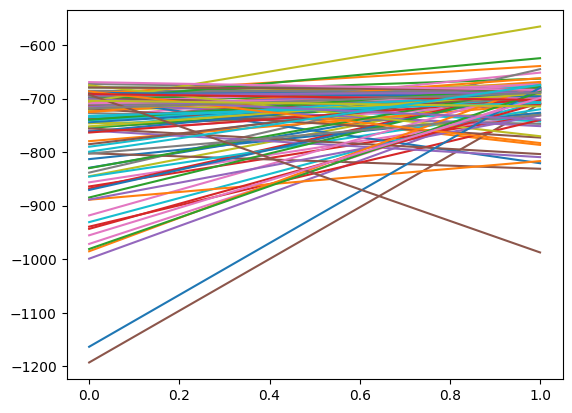

In [4]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(n_attempts):
    ax.plot(list(range(len(ll_list[i]))), ll_list[i])

plt.show()

Make a bar chart out of the fraction of correctly predicted states, given the true observations from $t=T_{\text{test}}$ onwards

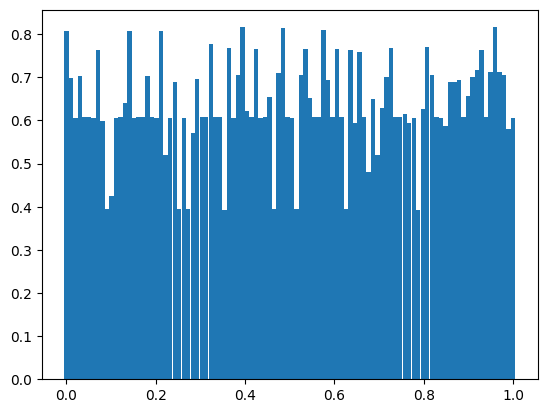

maximum pct correct: 0.8160000000000001 from attempt 40
minimum pct correct: 0.392 from attempt 36


In [5]:
plt.bar(np.linspace(0, 1, n_attempts), pct_states_matched_viterbi, width=1/(1 + n_attempts))
plt.show()

print('maximum pct correct:', np.max(pct_states_matched_viterbi), 'from attempt', np.argmax(pct_states_matched_viterbi) + 1)
print('minimum pct correct:', np.min(pct_states_matched_viterbi), 'from attempt', np.argmin(pct_states_matched_viterbi) + 1)

Plot the fraction of correct predictions for states and observations

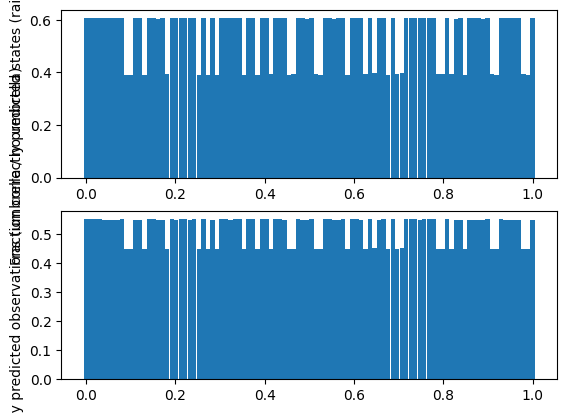

In [6]:

fig, (ax1, ax2) = plt.subplots(2)
ax1.bar(np.linspace(0, 1, n_attempts), frac_correct_states_predicted_list, width=1/(1 + n_attempts))
ax2.bar(np.linspace(0, 1, n_attempts), frac_correct_obs_predicted_list, width=1/(1 + n_attempts))
ax1.set_ylabel("Fraction correctly predicted states (rain / no rain)")
ax2.set_ylabel("Fraction correctly predicted observations (umbrella / no umbrella)")
plt.show()